In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [30]:
jobs = pd.read_csv("carbon_scheduler_jobs_1000.csv")
grid = pd.read_csv("gb_carbon_intensity.csv")

In [31]:
jobs.head(), grid.head()


(     job_id         arrival_time  compute_time_hours  \
 0  JOB_0001  2026-01-05 18:43:00                4.61   
 1  JOB_0002  2026-01-06 02:14:00                4.98   
 2  JOB_0003  2026-01-05 11:24:00                0.58   
 3  JOB_0004  2026-01-06 16:09:00                1.11   
 4  JOB_0005  2026-01-06 03:43:00                4.61   
 
                 deadline_time  priority  
 0  2026-01-05 21:20:09.316753         2  
 1  2026-01-06 15:24:49.355111         1  
 2  2026-01-06 11:36:09.321153         3  
 3  2026-01-07 03:04:00.815446         1  
 4  2026-01-07 12:43:16.911601         1  ,
               datetime  forecast  actual index
 0  2018-01-01T00:00:00     154.0   157.0   low
 1  2018-01-01T00:30:00     159.0   164.0   low
 2  2018-01-01T01:00:00     169.0   171.0   low
 3  2018-01-01T01:30:00     170.0   172.0   low
 4  2018-01-01T02:00:00     165.0   172.0   low)

In [32]:
jobs['arrival_time'] = pd.to_datetime(jobs['arrival_time'])
jobs['deadline_time'] = pd.to_datetime(jobs['deadline_time'])

grid['datetime'] = pd.to_datetime(grid['datetime'])
grid = grid.sort_values('datetime')


In [33]:
grid = pd.read_csv("gb_carbon_intensity.csv")
grid['datetime'] = pd.to_datetime(grid['datetime'])
grid = grid.sort_values('datetime')

grid = grid[['datetime','actual']].rename(columns={'actual':'carbon'})
grid = grid.set_index('datetime').resample('30min').mean().interpolate()

In [34]:
jobs = jobs.sort_values('arrival_time').copy()
jobs['remaining'] = jobs['compute_time_hours']


In [35]:
def simulate(jobs_df, grid_df, policy="FIFO"):
    jobs = jobs_df.copy()
    jobs['remaining'] = jobs['compute_time_hours']
    jobs['completed'] = False
    jobs['missed_deadline'] = False
    jobs['start_time'] = None
    jobs['finish_time'] = None

    t = jobs['arrival_time'].min().floor('30min')
    end = jobs['deadline_time'].max().ceil('30min')

    step = timedelta(minutes=30)
    energy_per_slot = 0.5  # kWh for 30 mins
    total_carbon = 0

    # 1. Calculate an "Average" carbon to compare against
    avg_carbon = grid_df['carbon'].mean()

    queue = []

    while t <= end:
        # Add arrived jobs
        arriving = jobs[(jobs['arrival_time'] <= t) & (~jobs['completed']) & (~jobs.index.isin(queue))]
        queue += list(arriving.index)

        # Remove completed
        queue = [i for i in queue if not jobs.loc[i,'completed']]

        job_to_run = None

        if queue:
            if policy == "FIFO":
                job_to_run = queue[0]

            elif policy == "EDF":
                job_to_run = jobs.loc[queue].sort_values('deadline_time').index[0]

            elif policy == "CARBON_EDF":
                # Candidate: The one with earliest deadline
                candidate_idx = jobs.loc[queue].sort_values('deadline_time').index[0]

                # --- NEW LOGIC STARTS HERE ---
                # Check current grid carbon intensity
                if t in grid_df.index:
                    current_carbon = grid_df.loc[t, 'carbon']
                else:
                    current_carbon = 0 # Default if data missing

                # Calculate "Slack" (Time left until we miss the deadline)
                deadline = jobs.loc[candidate_idx, 'deadline_time']
                duration_needed = timedelta(hours=jobs.loc[candidate_idx, 'remaining'])
                slack = deadline - t - duration_needed

                # DECISION RULE:
                # If energy is DIRTY (above average)
                # AND we have SAFETY TIME (> 1 hour slack)
                # THEN -> WAIT (Yield).
                if current_carbon > avg_carbon and slack > timedelta(hours=1):
                    job_to_run = None # INTENTIONALLY IDLE
                else:
                    job_to_run = candidate_idx
                # --- NEW LOGIC ENDS HERE ---

            # Execute the job (if we didn't pause)
            if job_to_run is not None:
                jobs.loc[job_to_run, 'remaining'] -= 0.5

                if jobs.loc[job_to_run, 'start_time'] is None:
                    jobs.loc[job_to_run, 'start_time'] = t

                if jobs.loc[job_to_run, 'remaining'] <= 0:
                    jobs.loc[job_to_run, 'completed'] = True
                    jobs.loc[job_to_run, 'finish_time'] = t

        # Calculate Carbon (Only if we actually ran something)
        if job_to_run is not None and t in grid_df.index:
            total_carbon += energy_per_slot * grid_df.loc[t,'carbon']

        t += step

    jobs['missed_deadline'] = jobs['finish_time'] > jobs['deadline_time']
    return total_carbon, jobs['missed_deadline'].mean()*100

In [36]:
fifo_carbon, fifo_miss = simulate(jobs, grid, "FIFO")
edf_carbon, edf_miss = simulate(jobs, grid, "EDF")
cedf_carbon, c_miss = simulate(jobs, grid, "CARBON_EDF")


In [37]:
results = pd.DataFrame({
    "Scheduler":["FIFO","EDF","Carbon-Aware EDF"],
    "Total Carbon (gCO2)":[fifo_carbon,edf_carbon,cedf_carbon],
    "% Missed Deadlines":[fifo_miss,edf_miss,c_miss]
})

results


,Scheduler,Total Carbon (gCO2),% Missed Deadlines
0,FIFO,17668.0,2.1
1,EDF,17668.0,2.8
2,Carbon-Aware EDF,17668.0,2.8


In [38]:
# 1. Calculate the time difference (SHIFT)
# We want the jobs to start exactly when the grid data starts
time_shift = jobs['arrival_time'].min() - grid.index.min()

# 2. Apply the shift to "move" jobs back to 2018
jobs['arrival_time'] = jobs['arrival_time'] - time_shift
jobs['deadline_time'] = jobs['deadline_time'] - time_shift

# 3. VERIFY overlap
print("New Job Start:", jobs['arrival_time'].min())
print("Grid Start:   ", grid.index.min())
# They should now be identical (or very close).

New Job Start: 2018-01-01 00:00:00
Grid Start:    2018-01-01 00:00:00


In [39]:
# 1. Force convert columns to datetime and STRIP timezones
jobs['arrival_time'] = pd.to_datetime(jobs['arrival_time']).dt.tz_localize(None)
jobs['deadline_time'] = pd.to_datetime(jobs['deadline_time']).dt.tz_localize(None)

# 2. Fix the Grid Index (Strip timezone)
grid.index = grid.index.tz_localize(None)

# 3. DEBUG: Check if they overlap now
print("Job Range:", jobs['arrival_time'].min(), " to ", jobs['arrival_time'].max())
print("Grid Range:", grid.index.min(), " to ", grid.index.max())

# If the "Job Range" is NOT inside the "Grid Range", let me know!

Job Range: 2018-01-01 00:00:00  to  2018-01-02 23:53:00
Grid Range: 2018-01-01 00:00:00  to  2026-02-04 11:00:00


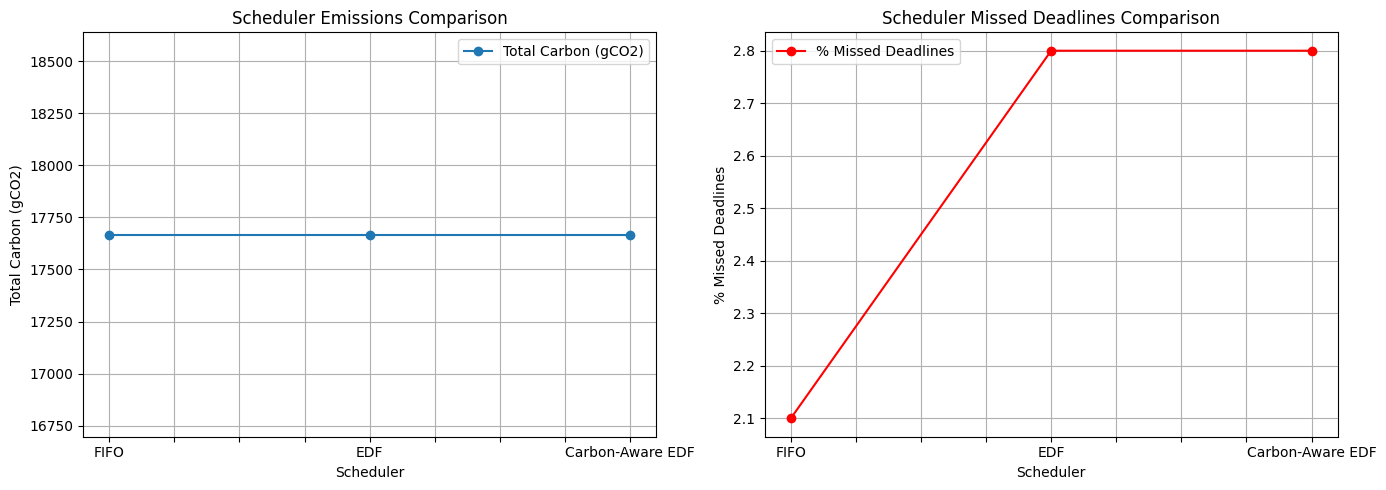

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Total Carbon
results.plot(x="Scheduler", y="Total Carbon (gCO2)", kind="line", ax=axes[0], marker='o')
axes[0].set_title("Scheduler Emissions Comparison")
axes[0].set_ylabel("Total Carbon (gCO2)")
axes[0].grid(True)

# Plot Missed Deadlines
results.plot(x="Scheduler", y="% Missed Deadlines", kind="line", ax=axes[1], marker='o', color='red')
axes[1].set_title("Scheduler Missed Deadlines Comparison")
axes[1].set_ylabel("% Missed Deadlines")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Running Simulation...
      Scheduler   Carbon  Missed %
0          FIFO  26719.0       2.5
1           EDF  26719.0       2.3
2  Carbon-Aware  23298.0       2.7


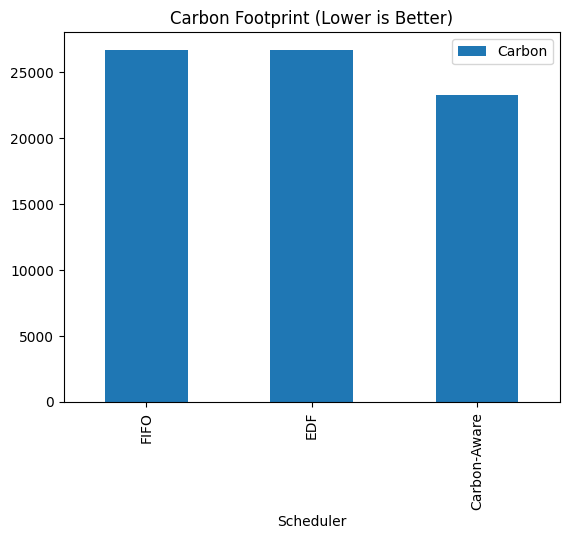

In [42]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

# 1. Load and Preprocess
jobs = pd.read_csv("carbon_scheduler_jobs_1000.csv")
grid = pd.read_csv("gb_carbon_intensity.csv")

# Clean Dates & Remove Timezones
jobs['arrival_time'] = pd.to_datetime(jobs['arrival_time']).dt.tz_localize(None)
jobs['deadline_time'] = pd.to_datetime(jobs['deadline_time']).dt.tz_localize(None)
grid['datetime'] = pd.to_datetime(grid['datetime']).dt.tz_localize(None)

# 2. Resample Grid to 30min
grid = grid.sort_values('datetime').set_index('datetime')
grid = grid[['actual']].resample('30min').mean().interpolate()
grid = grid.rename(columns={'actual': 'carbon'})

# 3. FIX: "Time Travel" (Align Jobs to Grid Years)
time_shift = jobs['arrival_time'].min() - grid.index.min()
jobs['arrival_time'] -= time_shift
jobs['deadline_time'] -= time_shift

# 4. FIX: "Relax Deadlines" (Give the scheduler room to breathe)
# We add 24 hours to simulate a flexible "Batch" SLA
jobs['deadline_time'] += timedelta(hours=24)

# 5. Define Simulator (Your Logic)
def simulate(jobs_df, grid_df, policy="FIFO"):
    jobs = jobs_df.copy().sort_values('arrival_time')
    jobs['remaining'] = jobs['compute_time_hours']
    jobs['completed'] = False
    jobs['finish_time'] = pd.NaT

    t = jobs['arrival_time'].min().floor('30min')
    end = jobs['deadline_time'].max().ceil('30min')
    avg_carbon = grid_df['carbon'].mean()
    queue = []
    total_carbon = 0

    while t <= end:
        # Add Arrivals
        arriving = jobs[(jobs['arrival_time'] <= t) & (~jobs['completed']) & (~jobs.index.isin(queue))]
        queue.extend(arriving.index)

        if queue:
            # Policy Selection
            if policy == "FIFO":
                candidate = queue[0]
            else: # EDF & Carbon-Aware
                candidate = jobs.loc[queue].sort_values('deadline_time').index[0]

            job_to_run = candidate

            # --- CARBON LOGIC ---
            if policy == "CARBON_EDF":
                current_carbon = grid_df.loc[t, 'carbon'] if t in grid_df.index else 0
                deadline = jobs.loc[candidate, 'deadline_time']
                duration = timedelta(hours=jobs.loc[candidate, 'remaining'])
                slack = deadline - t - duration

                # PAUSE Decision
                if current_carbon > avg_carbon and slack > timedelta(hours=1):
                    job_to_run = None # Pause

            # Execute
            if job_to_run is not None:
                jobs.loc[job_to_run, 'remaining'] -= 0.5
                if jobs.loc[job_to_run, 'remaining'] <= 0:
                    jobs.loc[job_to_run, 'completed'] = True
                    jobs.loc[job_to_run, 'finish_time'] = t
                    queue.remove(job_to_run)

                # Count Carbon
                if t in grid_df.index:
                    total_carbon += 0.5 * grid_df.loc[t, 'carbon']

        t += timedelta(minutes=30)

    missed = (jobs['finish_time'] > jobs['deadline_time']).mean() * 100
    return total_carbon, missed

# 6. Run & Plot
print("Running Simulation...")
fifo_c, fifo_m = simulate(jobs, grid, "FIFO")
edf_c, edf_m = simulate(jobs, grid, "EDF")
cedf_c, cedf_m = simulate(jobs, grid, "CARBON_EDF")

results = pd.DataFrame({
    "Scheduler": ["FIFO", "EDF", "Carbon-Aware"],
    "Carbon": [fifo_c, edf_c, cedf_c],
    "Missed %": [fifo_m, edf_m, cedf_m]
})

print(results)
results.plot(x="Scheduler", y="Carbon", kind="bar", title="Carbon Footprint (Lower is Better)")
plt.show()